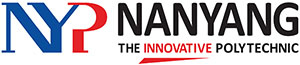

# Google Video Intelligence API

In this practical, we are going to learn about [Google Video Intelligence API](https://cloud.google.com/video-intelligence/). You can download and use a video file from Brightspace for the following exercises. Watch the video to familarise with the content.


Unlike Vision AI, Google does not have a demo for Video Intelligence. However, you can refer to this [Video Intelligence API Visualiser](https://zackakil.github.io/video-intelligence-api-visualiser/) to get a sense of the various types of detections offered by this API. 

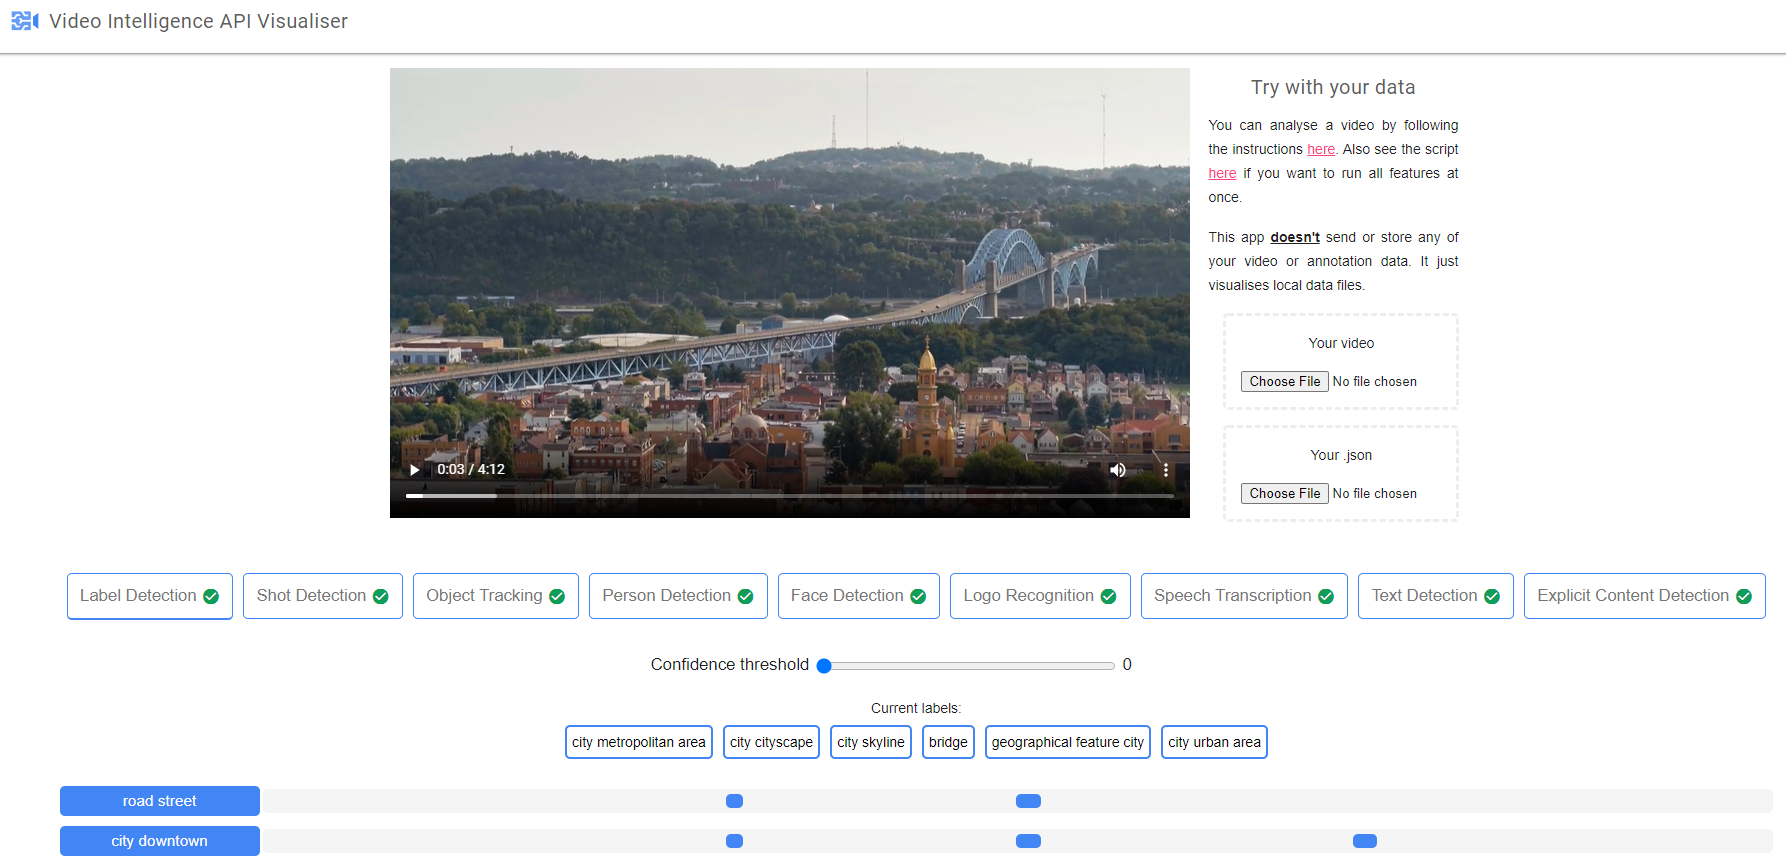

## Analyse videos for labels

The Video Intelligence API can identify entities shown in video footage using the [LABEL_DETECTION](https://cloud.google.com/video-intelligence/docs/analyze-labels) feature. This feature identifies objects, locations, activities, animal species, products, and more.

The analysis can be compartmentalized as follows:

- Frame level:
Entities are identified and labeled within each frame (with one frame per second sampling).
- Shot level:
Shots are automatically detected within every segment (or video). Entities are then identified and labeled within each shot.
- Segment level:
User-selected segments of a video can be specified for analysis by stipulating beginning and ending time offsets for the purposes of annotation. Entities are then identified and labeled within each segment. If no segments are specified, the whole video is treated as one segment

We will set up Video Intelligence for analysis at the frame and shot level.

### Using Client Library for Video Intelligence

In [ ]:
from google.cloud import videointelligence_v1 as videointelligence
import json
import os
import io

In [ ]:
video_filename = 'oh_2021_short.mp4'

In [ ]:
# make sure file is found
!dir it3386_practical.json

In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS

In [ ]:
# set the service key in envs
%env GOOGLE_APPLICATION_CREDENTIALS=it3386-2024-s2.json

In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS

In [ ]:
# https://cloud.google.com/video-intelligence/docs/analyze-labels
def analyze_label(path): 
    
    video_client = videointelligence.VideoIntelligenceServiceClient()
    features = [videointelligence.Feature.LABEL_DETECTION]

    mode = videointelligence.LabelDetectionMode.SHOT_AND_FRAME_MODE
    config = videointelligence.LabelDetectionConfig(label_detection_mode=mode)
    context = videointelligence.VideoContext(label_detection_config=config)

    with io.open(path, "rb") as movie:
        input_content = movie.read()

    operation = video_client.annotate_video(
        request={"features": features, "input_content": input_content, "video_context": context}
    )
    print("\nProcessing video for label annotations:")
    
    
    result = operation.result(timeout=300)
    print("\nFinished processing.")

    # Process video/segment level label annotations
    segment_labels = result.annotation_results[0].segment_label_annotations
    for i, segment_label in enumerate(segment_labels):
        print("Video label description: {}".format(segment_label.entity.description))
        for category_entity in segment_label.category_entities:
            print(
                "\tLabel category description: {}".format(category_entity.description)
            )

        for i, segment in enumerate(segment_label.segments):
            start_time = (
                segment.segment.start_time_offset.seconds
                + segment.segment.start_time_offset.microseconds / 1e6
            )
            end_time = (
                segment.segment.end_time_offset.seconds
                + segment.segment.end_time_offset.microseconds / 1e6
            )
            positions = "{}s to {}s".format(start_time, end_time)
            confidence = segment.confidence
            print("\tSegment {}: {}".format(i, positions))
            print("\tConfidence: {}".format(confidence))
        print("\n")

    # Process shot level label annotations
    shot_labels = result.annotation_results[0].shot_label_annotations
    for i, shot_label in enumerate(shot_labels):
        print("Shot label description: {}".format(shot_label.entity.description))
        for category_entity in shot_label.category_entities:
            print(
                "\tLabel category description: {}".format(category_entity.description)
            )

        for i, shot in enumerate(shot_label.segments):
            start_time = (
                shot.segment.start_time_offset.seconds
                + shot.segment.start_time_offset.microseconds / 1e6
            )
            end_time = (
                shot.segment.end_time_offset.seconds
                + shot.segment.end_time_offset.microseconds / 1e6
            )
            positions = "{}s to {}s".format(start_time, end_time)
            confidence = shot.confidence
            print("\tSegment {}: {}".format(i, positions))
            print("\tConfidence: {}".format(confidence))
        print("\n")

    # Process frame level label annotations
    frame_labels = result.annotation_results[0].frame_label_annotations
    for i, frame_label in enumerate(frame_labels):
        print("Frame label description: {}".format(frame_label.entity.description))
        for category_entity in frame_label.category_entities:
            print(
                "\tLabel category description: {}".format(category_entity.description)
            )

        # Each frame_label_annotation has many frames,
        # here we print information only about the first frame.
        frame = frame_label.frames[0]
        time_offset = frame.time_offset.seconds + frame.time_offset.microseconds / 1e6
        print("\tFirst frame time offset: {}s".format(time_offset))
        print("\tFirst frame confidence: {}".format(frame.confidence))
        print("\n")
    
    return result

In [ ]:
# shot and frame labels
result_label = analyze_label(video_filename)

In [ ]:
frame_labels = result_label.annotation_results[0].frame_label_annotations

In [ ]:
# print one random frame and analyse the keys and values
frame_labels[11]

In [ ]:
print(frame_labels[0].frames)

### Explore the frames

Entities are identified and labeled within each frame (with one frame per second sampling).

In [ ]:
# explore the first label
frame_labels[0]

Let's consolidate the frames and entities under <code>records</code>

In [ ]:
records = []
for label in frame_labels:
    #print(label)
    record = {'entity':'', 'category':'', 'frame':'', 'confidence':''}
    list_frames = []
    list_confidence = []
    list_categories = []
    list_entities = []
    
    record['entity'] = label.entity.description
    for cat_ent in label.category_entities:
        list_categories.append(cat_ent.description)
    record['category'] = ','.join(list_categories)
    
    for frame in label.frames:
        list_frames.append(str(frame.time_offset))
        list_confidence.append(str(round(frame.confidence*100)))
    
    record['frame'] = ','.join(list_frames)
    record['confidence'] = ','.join(list_confidence)
    records.append(record)
    
    '''
    record['entity'] = label.entity.description
    if 'category_entities' in label:
        for category in label.categoryEntities:
            list_categories.append(category.description)
            
    record['category'] = ','.join(list_categories)
    
    for frame in label.frames:
        list_frames.append(frame.timeOffset)
        list_confidence.append(str(round(frame.confidence*100)))
    '''

In [ ]:
# explore first element
records[0]

In [ ]:
from IPython.display import HTML, display

html = '<table><thead><tr><th>Entity</th><th>Category</th><th>Frame At</th><th>Confidence (%)</th></tr></thead><tbody>'

for record in records:
    entity = record['entity']
    category = record['category'].replace(',', '<br>')
    frame = record['frame'].replace(',', '<br>')
    confidence = record['confidence'].replace(',', '<br>')
    row = '<tr style="vertical-align:top"><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>'.format(entity, category, frame, confidence)
    html = html + row
    #break

html = html + '</tbody></table>'
display(HTML(html))



### Todo

> Use tools like Photos or VLC to play the video at certain frames to determine if the detections are accurate.


### Explore the Shots

Shots are automatically detected within every segment (or video). Entities are then identified and labeled within each shot.

In [ ]:
result_label.annotation_results[0].shot_label_annotations

In [ ]:
label_shots = result_label.annotation_results[0].shot_label_annotations

In [ ]:
# Explore first element
label_shots[0]

In [ ]:
# find a label with more than 1 segment
label_shots[4]

Each segment label includes a description, a list of entity categories, and a list of segments identifying the start/end time of the label occurrences in the video.

In [ ]:
for idx, label in enumerate(label_shots):
    #print(label)
    print('{} Entity: {}'.format(idx, label.entity.description))
    #if 'categoryEntities' in label:
    for category in label.category_entities:
        print('Category: {}'.format(category.description))
    
    # no need to break up segment first
    for segment in label.segments:
        print('Start Time Offset: {}'.format(segment.segment.start_time_offset))
        print('End Time Offset: {}'.format(segment.segment.end_time_offset))
        print('Confidence: {}'.format(segment.confidence))
    
    print('\n')

### Analyse the predictions

Based on the shots detected in the video, extract a few frames to display and see if the prediction is accurate.

In [ ]:
# create an output directory to hold the generated files
dir_output = 'output'
if not os.path.isdir(dir_output):
    os.makedirs(dir_output)

In [ ]:
# Use conda to manage dependencies across packages
# conda installation is done outside notebook in Anaconda prompt
# conda install -c conda-forge moviepy

In [ ]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
from pathlib import Path

# entity will be the filename 
def get_gif_and_mp4_filename(video_source_filename, start_time, stop_time, entity):
    output_filename_video = str(Path(dir_output + '/' + entity.replace(' ', '_') + '.mp4'))
    output_filename_gif = str(Path(dir_output + '/' + entity.replace(' ', '_') + '.gif'))

    clip = VideoFileClip(video_source_filename, audio=False).subclip(start_time, stop_time)
    clip.write_videofile(output_filename_video)
    clip.close()
    
    clip_segment = VideoFileClip(output_filename_video, audio=False)
    clip_segment.write_gif(output_filename_gif)
    return output_filename_gif, output_filename_video

In [ ]:
print(video_filename)

In [ ]:
# choose an index
index = 8
print(label_shots[index])
time_offset_start = label_shots[index].segments[0].segment.start_time_offset.seconds
time_offset_end = label_shots[index].segments[0].segment.end_time_offset.seconds

entity_description = label_shots[index].entity.description
print(entity_description)

In [ ]:
'''
Example entity

Entity: lecture
Start Time Offset: 22.720s
End Time Offset: 23.760s
'''

from IPython import display

filename_gif, filename_mp4 = get_gif_and_mp4_filename(video_filename, time_offset_start, time_offset_end, entity_description)


In [ ]:
# takes a while to display the gif
display.Image(filename_gif, width=320)

Alternatively, we can export and explore the frames

In [ ]:
clip_segment = VideoFileClip(filename_mp4)
clip_segment.write_images_sequence('output/frame%04d.jpg', verbose=True)

Once the frames are successfully converted to images, you will see the first file under 'output/frame0000.jpg'. Display the first image.

In [ ]:
print(entity_description)
display.Image('output/frame0000.jpg', width=320)

### Todo 

> Display more frames? Are the predictions accurate?

Ref
- https://videointelligence.googleapis.com/v1/videos:annotate
- https://cloud.google.com/video-intelligence/docs/label-tutorial